This notebook assumes access to detrended, denoised signals and calculates various parameters (and uncertainties) from these signals and serves as an area for experimentation with methods for parameter estimation. The parameters estimated within this notebook are split into three different types: time-domain, frequency-domain and non-linear:

Time domain:
 - mean RR intervals
 - std RR intervals 
 - mean amplitude
 - RMSSD of differences between successive RR intervals 
 - pNN50 (%) NN50 divided by total number of RR (NN50 is the number of sucessive RR intervals that differ by more than 50ms) 
 - signal moments
 
 
Frequency Domain:
- absolute power of LF (0.04 - 0.15 Hz) band
- absolute power of HF (0.15 to 0.4Hz) band
- LF/HF ratio
- Total power (0-0.4 Hz)

Non-linear:
- Fractal dimension of dynamic attractor of signal
- std of poincare
- Shannon entropy
- recurrence rate
- detrended fluctuation analysis
- correlation dimension
- sample entropy


In [1]:
%run "Data_PreProcessing.ipynb" #allowing access to the filtered database with preprocessed signals

100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:28<00:00,  7.63it/s]


In [2]:
from scipy.signal import find_peaks, correlate
import neurokit2 as nk 
from pyhrv.hrv import hrv
import biosppy

In [3]:
test_indice = 134#set test signal to be used throughout notebook #219 is healthy
test_channel_indice = 0 #set test channel to be used throughout notebook
test_signal = denoised_signals[test_indice][test_channel_indice]

# Get R-peaks series using biosppy
if not np.isnan(test_signal).all():
    t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(test_signal, show=False)[:3]
    test_rpeaks =t[rpeaks]
else:
    print('test signal nan')


In [4]:
denoised_signals_one_channel = denoised_signals[:, test_channel_indice]#set test channel to be used throughout notebook

In [5]:
#finding the health array for the desired channel
nan_indices = []
health_state = allowed_patients.get_diagnoses()
for j in range(0, no_channels):
    signal_nan_indices = []
    for i, signal in enumerate(denoised_signals[:, j]):
        if np.isnan(signal).all():
            signal_nan_indices.append(False)
        else:
            signal_nan_indices.append(True)
    nan_indices.append(signal_nan_indices)
    


test_nan_indices = nan_indices[test_channel_indice]

health_state = np.array(health_state)
signal_health_state = health_state[np.array(test_nan_indices)]

In [6]:
def parameter_averages(parameter, health_state):
    """
    calculates healthy and unhealthy means and std of parameter for easy comparisson
    returns np.array containing: healthy mean, healthy std, unhealthy mean, unhealhty std
    """
    encoded_health_state = [True if label == 'Unhealthy' else False for label in health_state]
    
    unhealthy_param = parameter[encoded_health_state]
    healthy_param = parameter[~np.array(encoded_health_state)]
    
    # Filter out NaN and inf values
    unhealthy_param = unhealthy_param[np.isfinite(unhealthy_param)]
    healthy_param = healthy_param[np.isfinite(healthy_param)]

    unhealthy_param_av = np.mean(unhealthy_param)
    unhealthy_param_std = np.std(unhealthy_param)
    
    healthy_param_av = np.mean(healthy_param)
    healthy_param_std = np.std(healthy_param)
    
    return np.array([healthy_param_av, healthy_param_std, unhealthy_param_av, unhealthy_param_std])

def print_averages(parameter, parameter_name, nan_indices):
    health_state = allowed_patients.get_diagnoses()

    nan_indices = np.array(nan_indices)
    health_state = np.array(health_state)
    
    channel_health_state = health_state[nan_indices]
    
    means = parameter_averages(parameter, channel_health_state)
    
    print(f"Unhealthy {parameter_name}: mean:{means[2]}, std: {means[3]}")
    print(f"Healthy {parameter_name}: mean:{means[0]}, std:{means[1]}")
    return None

def outliers_indices_z_score(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    indices = np.argwhere([abs(z)<threshold for z in z_scores])
    return indices

def get_peaks(signal):
    peak_dict, info = nk.ecg_peaks(signal, sampling_rate=1000)
    peaks = info['ECG_R_Peaks']
    
    #calculating amplitude of R peak
    peak_amp = signal[peaks] - np.median(signal) #median used as baseline
    peak_amp_av = np.mean(peak_amp)
    # peak_amp_std = np.std(peak_amp)   
    return peaks, peak_amp_av
        

def get_rri(signal, remove_outliers=False):
    peaks, amps = get_peaks(signal)

    # calculates rr intervals
    rri = np.diff(peaks)
    
    number_outliers = 0
    
    #removal of outliers
    if remove_outliers:
        rri_outlier_indices = outliers_indices_z_score(rri).reshape(-1)
        rr_intervals = rri[rri_outlier_indices]
        number_outliers += (len(rri) - len(rr_intervals))
        
    else:
        rr_intervals = rri
        number_outliers = None
    #rr_intervals = rri
        
    return rr_intervals, amps, number_outliers
    

    

In [19]:
def calculate_sample_entropy(signal, m=2, r=0.2):
    rr_intervals = get_rri(signal)[0]
    N = len(rr_intervals)
    r *= np.std(rr_intervals)  # tolerance r is usually set as a fraction of the standard deviation
    
    def _phi(m):
        X = np.array([rr_intervals[i:i + m] for i in range(N - m + 1)])
        C = np.sum(np.max(np.abs(X[:, None] - X[None, :]), axis=2) <= r, axis=0) - 1
        return np.sum(C) / (N - m + 1)
    return -np.log((_phi(m + 1)) / (_phi(m)))

In [20]:
samp_ens = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        samp_en = calculate_sample_entropy(signal)
        samp_ens[i] = samp_en
        i+=1

In [9]:
nk_sd1s = np.zeros(shape=len(signal_health_state))
nk_sd2s = np.zeros(shape = len(signal_health_state))
nk_sd_ratios = np.zeros(shape = len(signal_health_state))
nk_shannons = np.zeros(shape = len(signal_health_state))
nk_sampens = np.zeros(shape = len(signal_health_state))
nk_fuzzys = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:

    if not np.isnan(signal).all():
        print(len(signal))
        peaks, info = nk.ecg_peaks(signal, sampling_rate=1000)
        nl_indices = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=False)
        nk_sd1s[i] = nl_indices['HRV_SD1']
        nk_sd2s[i] = nl_indices['HRV_SD2']
        nk_sd_ratios[i] = nl_indices['HRV_SD1SD2']
        nk_shannons[i] = nl_indices['HRV_ShanEn']
        nk_sampens[i] = nl_indices['HRV_SampEn']
        nk_fuzzys[i] = nl_indices['HRV_FuzzyEn']
        i+=1

60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
6000

## Time Domain

### Peak to Peak times and Peak amplitude (R)

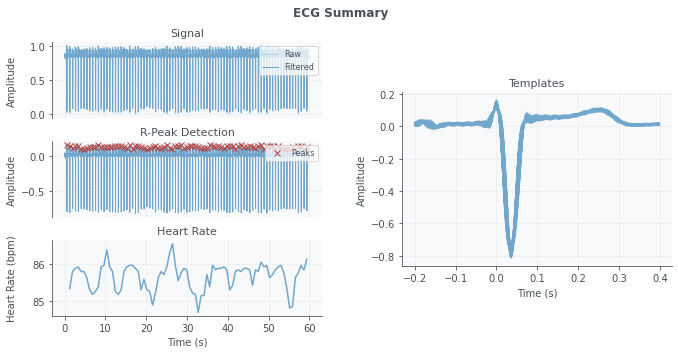

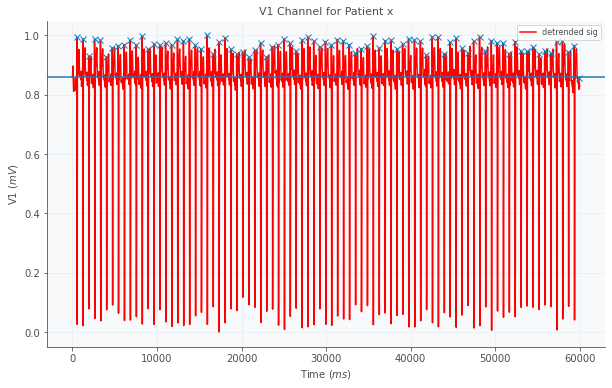

In [10]:
peaks, amp = get_peaks(test_signal)

import neurokit2 as nk 
peak_dict, info = nk.ecg_peaks(test_signal, sampling_rate=1000)
nkpeaks = info['ECG_R_Peaks']

# Get R-peaks series using biosppy
t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(test_signal)[:3]

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(test_signal, color = 'red', label = 'detrended sig')
ax.plot(nkpeaks, test_signal[nkpeaks], 'x')
ax.axhline(np.median(test_signal))

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(f'V{test_channel_indice+1} ($mV$)')
ax.set_title(f'V{test_channel_indice+1} Channel for Patient x')

ax.legend()
plt.show()

In [11]:
peaks, info = nk.ecg_peaks(test_signal, sampling_rate=1000)

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,698.223529,20.848305,NaN,NaN,NaN,NaN,NaN,NaN,21.835696,21.849912,...,0.653517,3.627843,0.681249,0.383482,0.5476,0.449802,0.69733,2.019706,1.425292,0.98026


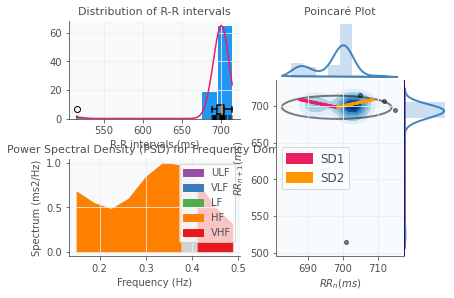

In [12]:
hrv_indices = nk.hrv(peaks, sampling_rate=1000, show=True)
hrv_indices

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN'],
      dtype='object')

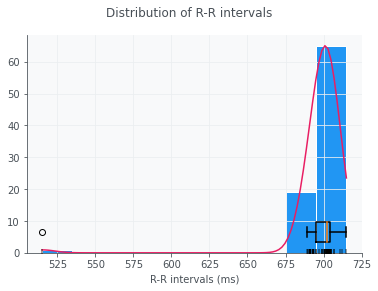

In [13]:
hrv_indices = nk.hrv_time(peaks, sampling_rate=1000, show=True)
hrv_indices.columns

identified peaks, should get rid of first and last values in it, wont hurt much even if is correct ones. I shall now implement a function to perform this for all signals in the database, may have to find a way to automatically calculate the distance between signals, find way to get rid of outliers....
- remove outliers - no because want to keep the arythmic activity
- remove first and last values
- dont investigate R-amplitude

R–R intervals differing more than 20% of the mean R–R interval were removed. A linear interpolation was used in order to replace the removed beats. On the other hand, the R–R series with R–R exclusion greater than 20% were excluded from the analysis. - Spectral analysis of heart rate variability with the autoregressive method: What model order to choose? SHOULD TRY THIS??

In [14]:
def RR_analysis(signal, remove_outliers=False):
    peak_distances, amps, number_outliers = get_rri(signal, remove_outliers)
    
    # stastitical analysis on rr intervals
    mean_RR = np.mean(peak_distances)
    std_RR = np.std(peak_distances)

    #RMSSD
    # computes differences between successive RR intervals for RMSSD
    diff_RR_intervals = np.diff(peak_distances)
    
    RMSSD_RR = np.sqrt(np.mean(diff_RR_intervals**2))
    
    #pNN50
    # the number of successive RR intervals that differ by more than 50 ms 
    NN50 = np.sum(np.abs(diff_RR_intervals) > 0.050)
    # divide by total number of RR intervals
    pNN50 = (NN50 / len(peak_distances)) * 100
    
    return mean_RR, std_RR, RMSSD_RR, pNN50, amps, number_outliers



rr_means = np.zeros(shape = len(signal_health_state))
rr_stds = np.zeros(shape = len(signal_health_state))
rr_RMSSD = np.zeros(shape = len(signal_health_state))
rr_pNN50s = np.zeros(shape = len(signal_health_state))
rr_amps = np.zeros(shape= len(signal_health_state))
n_outliers = np.zeros(shape = len(signal_health_state))
i = 0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        rr_mean, rr_std, rr_rmssd, rr_pNN50, amps, number_outliers = RR_analysis(signal, remove_outliers=False)
        rr_means[i] = rr_mean
        rr_stds[i] = rr_std
        rr_RMSSD[i] = rr_rmssd
        rr_pNN50s[i] = rr_pNN50
        rr_amps[i] = amps
        n_outliers[i] = number_outliers
        i+=1

In [15]:
print_averages(rr_means, 'RR means', test_nan_indices)
print_averages(rr_stds, 'RR stds', test_nan_indices)
print_averages(rr_RMSSD, 'RMSSDs', test_nan_indices)
print_averages(rr_pNN50s, 'pNN50s', test_nan_indices)
print_averages(rr_amps, 'amplitudes', test_nan_indices)
print_averages(n_outliers, 'num outliers', test_nan_indices)

Unhealthy RR means: mean:809.0865632981455, std: 171.3838425848001
Healthy RR means: mean:877.9138144263922, std:139.17342497115266
Unhealthy RR stds: mean:62.445457785525065, std: 78.37922563153036
Healthy RR stds: mean:44.57731350928216, std:26.72269677475887
Unhealthy RMSSDs: mean:86.42007453251193, std: 116.1416822161973
Healthy RMSSDs: mean:46.739900407322466, std:43.284836350774896
Unhealthy pNN50s: mean:92.57922166771225, std: 5.70306301691873
Healthy pNN50s: mean:94.97632809472502, std:3.171080448378599
Unhealthy amplitudes: mean:0.14937496323409574, std: 0.15038462490657853
Healthy amplitudes: mean:0.19106706595874667, std:0.08019382390175174
Unhealthy num outliers: mean:nan, std: nan
Healthy num outliers: mean:nan, std:nan


In [16]:
#comparisson with pyhrv
import pyhrv.time_domain as td

nn_means = np.zeros(shape = len(signal_health_state))
nn_stds = np.zeros(shape = len(signal_health_state))
nn_RMSSD = np.zeros(shape = len(signal_health_state))
nn_pNN50s = np.zeros(shape = len(signal_health_state))
nn_hrs = np.zeros(shape = len(signal_health_state))
nn_hrs_std = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]

        # Compute parameters using R-peak series
        nn_mean = td.nni_parameters(rpeaks=rpeaks)['nni_mean']

        nn_std = td.sdnn(rpeaks=rpeaks)['sdnn']

        nn_rmssd = td.rmssd(rpeaks=rpeaks)['rmssd']

        nn_pNN50 = td.nn50(rpeaks=rpeaks)['pnn50']

        nn_hr = td.hr_parameters(rpeaks=rpeaks)['hr_mean']
        nn_hr_std = td.hr_parameters(rpeaks=rpeaks)['hr_std']

        nn_means[i] = nn_mean
        nn_stds[i] = nn_std
        nn_RMSSD[i] = nn_rmssd
        nn_pNN50s[i] = nn_pNN50
        nn_hrs[i] = nn_hr
        nn_hrs_std[i] = nn_hr_std
        i+=1

In [17]:
print_averages(nn_means, 'nn means', test_nan_indices)
print_averages(nn_stds, 'nn stds', test_nan_indices)
print_averages(nn_RMSSD, 'nn RMSSDs', test_nan_indices)
print_averages(nn_pNN50s, 'nn pNN50s', test_nan_indices)
print_averages(nn_hrs, 'nn HR', test_nan_indices)
print_averages(nn_hrs_std, 'nn HR std', test_nan_indices)

Unhealthy nn means: mean:828.1906143760067, std: 200.47996298099076
Healthy nn means: mean:878.0177434361369, std:139.15552321377146
Unhealthy nn stds: mean:54.84792452855525, std: 65.6056860358375
Healthy nn stds: mean:44.205078769323016, std:26.903363935965714
Unhealthy nn RMSSDs: mean:74.46260363343971, std: 99.8831221271125
Healthy nn RMSSDs: mean:44.83840356648729, std:43.225664702167094
Unhealthy nn pNN50s: mean:22.116128957556665, std: 28.637037492386575
Healthy nn pNN50s: mean:16.418872305230376, std:21.16401173014916
Unhealthy nn HR: mean:76.94006599661029, std: 16.422292354035687
Healthy nn HR: mean:70.42549937837654, std:11.858260133768235
Unhealthy nn HR std: mean:5.4769650127962155, std: 8.299274904069952
Healthy nn HR std: mean:3.6797910714757402, std:2.4786361746702097


In [18]:
#neurokit
nk_nn_means = np.zeros(shape = len(signal_health_state))
nk_nn_stds = np.zeros(shape = len(signal_health_state))
nk_nn_RMSSD = np.zeros(shape = len(signal_health_state))
nk_nn_pNN50s = np.zeros(shape = len(signal_health_state))
nk_nn_iqr = np.zeros(shape = len(signal_health_state))
nk_nn_median = np.zeros(shape=len(signal_health_state))
nk_nn_mad = np.zeros(shape=len(signal_health_state))
nk_nn_HTI = np.zeros(shape=len(signal_health_state))
nk_nn_TINN = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        peaks, info = nk.ecg_peaks(signal, sampling_rate=1000)
        hrv_indices = nk.hrv_time(peaks, sampling_rate=1000, show=False)

        # Compute parameters using R-peak series
        nn_mean = hrv_indices['HRV_MeanNN']

        nn_std = hrv_indices['HRV_SDNN']

        nn_rmssd = hrv_indices['HRV_RMSSD']

        nn_pNN50 = hrv_indices['HRV_pNN50']

        nn_IQR = hrv_indices['HRV_IQRNN']

        nn_median = hrv_indices['HRV_MedianNN']

        nn_mad = hrv_indices['HRV_MadNN']

        nn_HTI = hrv_indices['HRV_HTI']

        nn_TINN = hrv_indices['HRV_TINN']

        nk_nn_means[i] = nn_mean
        nk_nn_stds[i] = nn_std
        nk_nn_RMSSD[i] = nn_rmssd
        nk_nn_pNN50s[i] = nn_pNN50
        nk_nn_iqr[i] = nn_IQR
        nk_nn_median[i] = nn_median
        nk_nn_mad[i] = nn_mad
        nk_nn_HTI[i] = nn_HTI
        nk_nn_TINN[i] = nn_TINN
        i+=1


KeyboardInterrupt: 

In [ ]:
print_averages(nk_nn_means, 'nn means', test_nan_indices)
print_averages(nk_nn_stds, 'nn stds', test_nan_indices)
print_averages(nk_nn_RMSSD, 'nn RMSSDs', test_nan_indices)
print_averages(nk_nn_pNN50s, 'nn pNN50s', test_nan_indices)
print_averages(nk_nn_iqr, 'nn IQR', test_nan_indices)
print_averages(nk_nn_median, 'nn median', test_nan_indices)
print_averages(nk_nn_mad, 'nn mad', test_nan_indices)
print_averages(nk_nn_HTI, 'nn HTI', test_nan_indices)
print_averages(nk_nn_TINN, 'nn TINN', test_nan_indices)


### QRS complex duration

In [ ]:
cleaned_test_signal = nk.ecg_clean(test_signal, sampling_rate=1000)

wave_dict, signals_df = nk.ecg_delineate(cleaned_test_signal, rpeaks=nkpeaks)

In [ ]:
q_onset = signals_df['ECG_Q_Peaks']
s_onset = signals_df['ECG_S_Peaks']

In [ ]:
print(len(q_onset))
print(len(s_onset))
qrs_duration = np.array(s_onset) - np.array(q_onset)
print(qrs_duration)

In [ ]:
qrs_mean = np.zeros(shape = len(signal_health_state))
qrs_std = np.zeros(shape = len(signal_health_state))


i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        cleaned_signal = nk.ecg_clean(signal, sampling_rate=1000)
        
        peak_dict, info = nk.ecg_peaks(cleaned_signal, sampling_rate=1000)
        nkpeaks = info['ECG_R_Peaks']
        
        wave_dict, signals_df = nk.ecg_delineate(signal)
        
        q_peaks = signals_df['ECG_Q_Peaks']
        s_peaks = signals_df['ECG_S_Peaks']
        
        qrs = np.array(s_peaks) - np.array(q_peaks)
        
        qrs_mean[i] = np.nanmean(qrs)
        qrs_std[i] = np.nanstd(qrs)

        i+=1

In [ ]:
print(qrs_mean)

In [ ]:
print_averages(qrs_mean, 'qrs means', test_nan_indices)
print_averages(qrs_std, 'qrs stds', test_nan_indices)

In [ ]:
from scipy.stats import skew, kurtosis

def get_moments(signal, remove_outliers):
    mean = np.mean(signal)
    std = np.std(signal)
    skew_ecg = skew(signal)
    kurtosis_ecg = kurtosis(signal)
    return mean, std, skew_ecg, kurtosis_ecg

means = np.zeros(shape = len(signal_health_state))
stds = np.zeros(shape = len(signal_health_state))
skews = np.zeros(shape = len(signal_health_state))
kurtosiss = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        mean, std, ecg_skew, ecg_kurtosis = get_moments(signal, remove_outliers=True)
        means[i] = mean
        stds[i] = std
        skews[i] = ecg_skew
        kurtosiss[i] = ecg_kurtosis
        i+=1


In [ ]:
print_averages(means, 'means', test_nan_indices)
print_averages(stds, 'stds', test_nan_indices)
print_averages(skews, 'skews', test_nan_indices)
print_averages(kurtosiss, "kurtosis'", test_nan_indices)

## Frequency Domain

### Power Bands

In [ ]:
from scipy.signal import welch
from scipy.interpolate import interp1d

fs = 1000 #Hz
fs_interpolate = 3 #Hz

peaks, _ = find_peaks(test_signal, distance=600)
rr_intervals = np.diff(peaks)/fs # RR intervals in seconds, fs is the sampling frequency of the original signal
    
# Time points of the RR intervals
rr_times = np.cumsum(rr_intervals)
rr_times = np.insert(rr_times, 0, 0)  # Add time zero at the beginning

# Interpolation
interpolated_time = np.arange(0, rr_times[-2], 1/fs_interpolate)  # Interpolated time vector

interpolated_rr = interp1d(rr_times[:-1], rr_intervals, kind='cubic')(interpolated_time)

f, psd = welch(interpolated_rr, fs=fs_interpolate, nperseg=128)

# print(f)
# print(psd)

# Define frequency bands
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.40)

# Integrate the power spectral density over the frequency bands
lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])

In [ ]:
def power_bands(signal):
    fs = 1000 #Hz
    fs_interpolate = 3 #Hz
    
    # define frequency bands
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.40)
    
    peak_dict, info = nk.ecg_peaks(signal, sampling_rate=1000)
    peaks = info['ECG_R_Peaks']

    rr_intervals = np.diff(peaks)/fs # RR intervals in seconds, fs is the sampling frequency of the original signal
    
    # time points of the RR intervals
    rr_times = np.cumsum(rr_intervals)
    rr_times = np.insert(rr_times, 0, 0)  # add time zero at the beginning

    # Interpolation
    interpolated_time = np.arange(0, rr_times[-2], 1/fs_interpolate)  # Interpolated time vector
    interpolated_rr = interp1d(rr_times[:-1], rr_intervals, kind='cubic')(interpolated_time)

    #welch spectrum
    f, psd = welch(interpolated_rr, fs=fs_interpolate, nperseg=128)
    
    # Integrate the power spectral density over the frequency bands
    lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
    hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
    
    # Total power
    total_power = np.trapz(psd, f)
    
    return lf_power, hf_power, lf_power/hf_power, total_power
    

In [ ]:
lfs = np.zeros(shape = len(signal_health_state))
hfs = np.zeros(shape = len(signal_health_state))
ratios = np.zeros(shape = len(signal_health_state))
TPs = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        lf, hf, ratio, tp = power_bands(signal)
        lfs[i] = lf
        hfs[i] = hf
        ratios[i] = ratio
        TPs[i] = tp
        i+=1

In [ ]:
print_averages(lfs, 'lf_power', test_nan_indices)
print_averages(hfs, 'hf_power', test_nan_indices)
print_averages(ratios, 'ratio of power bands', test_nan_indices)
print_averages(TPs, 'total power', test_nan_indices)

In [ ]:
#comparisson with pyhrv
import pyhrv.frequency_domain as freq_dom

py_ulfs = np.zeros(shape = len(signal_health_state))
py_lfs = np.zeros(shape = len(signal_health_state))
py_hfs = np.zeros(shape = len(signal_health_state))
py_ratios = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]

        freq_feat = freq_dom.welch_psd(rpeaks = rpeaks, show = False, show_param=False, legend=False)
        py_ulfs[i] = freq_feat['fft_abs'][0]
        py_lfs[i] = freq_feat['fft_abs'][1]
        py_hfs[i] = freq_feat['fft_abs'][2]

        py_ratios[i] = freq_feat['fft_ratio']
        i+=1
    

In [ ]:
print_averages(py_lfs, 'lf_power', test_nan_indices)
print_averages(py_hfs, 'hf_power', test_nan_indices)
print_averages(py_ratios, 'ratio of power bands', test_nan_indices)
print_averages(py_ulfs, 'ulf_power', test_nan_indices)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(f, psd)
plt.title('Power Spectral Density of Interpolated RR Intervals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (ms^2/Hz)')
plt.grid()
plt.show()

In [ ]:
#neurokit
nk_ULF = np.zeros(shape = len(signal_health_state))
nk_VLF = np.zeros(shape = len(signal_health_state))
nk_LF = np.zeros(shape = len(signal_health_state))
nk_HF = np.zeros(shape = len(signal_health_state))
nk_TP = np.zeros(shape = len(signal_health_state))
nk_LFHF = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        peaks, info = nk.ecg_peaks(signal, sampling_rate=1000)
        freq_indices = nk.hrv_frequency(peaks, sampling_rate=1000, show=False)

        # Compute parameters using R-peak series
        ULF = freq_indices['HRV_ULF']

        VLF = freq_indices['HRV_VLF']

        LF = freq_indices['HRV_LF']

        HF = freq_indices['HRV_HF']

        TP = freq_indices['HRV_TP']

        power_ratio = freq_indices['HRV_LFHF']

        nk_ULF[i] = ULF
        nk_VLF[i] = VLF
        nk_LF[i] = LF
        nk_HF[i] = HF
        nk_TP[i] = TP
        nk_LFHF[i] = power_ratio
        i+=1

In [ ]:
print_averages(nk_ULF, 'ULF', test_nan_indices)
print_averages(nk_VLF, 'VLF', test_nan_indices)
print_averages(nk_LF, 'LF', test_nan_indices)
print_averages(nk_HF, 'HF', test_nan_indices)
print_averages(nk_TP, 'TP', test_nan_indices)
print_averages(nk_LFHF, 'ratio', test_nan_indices)


### DWT


In [ ]:
def single_DWT(signal, wavelet='db4'):
    coeffs = pywt.dwt(signal, wavelet)
    mean = np.zeros(shape=len(coeffs))
    std = np.zeros(shape=len(coeffs))
    coeff_min = np.zeros(shape=len(coeffs))
    coeff_max = np.zeros(shape=len(coeffs))
    for i, coeff in enumerate(coeffs):
        mean[i] = np.mean(coeff)
        std[i] = np.std(coeff)
        coeff_min[i] = np.min(coeff)
        coeff_max[i] = np.max(coeff)
    return mean, std, coeff_min, coeff_max
    

In [ ]:
DWT_means = np.zeros(shape = (len(signal_health_state), 2))
DWT_stds = np.zeros(shape = (len(signal_health_state), 2))
DWT_mins = np.zeros(shape = (len(signal_health_state), 2))
DWT_maxs = np.zeros(shape = (len(signal_health_state), 2))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        DWT_mean, DWT_std, DWT_min, DWT_max = single_DWT(signal)
        DWT_means[i] = DWT_mean 
        DWT_stds[i] = DWT_std
        DWT_mins[i] = DWT_min
        DWT_maxs[i] = DWT_max
        i+=1

In [ ]:
print_averages(DWT_means[:, 0], 'mean approx coeff', test_nan_indices)
print('---')
print_averages(DWT_means[:, 1], 'mean detail coeff', test_nan_indices)
print('---')
print_averages(DWT_stds[:, 0], 'std approx coeff', test_nan_indices)
print('---')
print_averages(DWT_stds[:, 1], 'std detail coeff', test_nan_indices)
print('---')
print_averages(DWT_mins[:, 0], 'min approx coeff', test_nan_indices)
print('---')
print_averages(DWT_mins[:, 1], 'min detail coeff', test_nan_indices)
print('---')
print_averages(DWT_maxs[:, 0], 'max approx coeff', test_nan_indices)
print('---')
print_averages(DWT_maxs[:, 1], 'max detail coeff', test_nan_indices)

In [ ]:
def multi_DWT(signal, level, wavelet='db4'):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    mean = np.zeros(shape=len(coeffs))
    std = np.zeros(shape=len(coeffs))
    coeff_min = np.zeros(shape=len(coeffs))
    coeff_max = np.zeros(shape=len(coeffs))
    for i, coeff in enumerate(coeffs):
        mean[i] = np.mean(coeff)
        std[i] = np.std(coeff)
        coeff_min[i] = np.min(coeff)
        coeff_max[i] = np.max(coeff)
    return mean, std, coeff_min, coeff_max
    
level = 8
    
multi_DWT_means = np.zeros(shape = (len(signal_health_state), level+1))
multi_DWT_stds = np.zeros(shape = (len(signal_health_state), level+1))
multi_DWT_mins = np.zeros(shape = (len(signal_health_state), level+1))
multi_DWT_maxs = np.zeros(shape = (len(signal_health_state), level+1))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        multi_DWT_mean, multi_DWT_std, multi_DWT_min, multi_DWT_max = multi_DWT(signal, level)
        multi_DWT_means[i] = multi_DWT_mean 
        multi_DWT_stds[i] = multi_DWT_std
        multi_DWT_mins[i] = multi_DWT_min
        multi_DWT_maxs[i] = multi_DWT_max
        i+=1



In [ ]:
for i in range(0, multi_DWT_means.shape[1]):
    print_averages(multi_DWT_means[:, i], f'mean approx coeff {i}', test_nan_indices)
    print('---')
    

## Non-Linear Domain

### Standard deviation of Poincare Plot
plot of each rr interval against the next, essentially a phase plot

In [ ]:
def plot_poincare(rr_intervals, compare=False):
    x = rr_intervals[:-1]
    y = rr_intervals[1:]
    
    if compare:
        removed_outliers = rr_intervals[outliers_indices_z_score(rr_intervals)]
        filtx = removed_outliers[:-1]
        filty = removed_outliers[1:]
        diff = len(rr_intervals) - len(removed_outliers)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
        ax2.scatter(filtx, filty, s=10, alpha=0.5)
        ax2.plot(filtx, filtx, color='red', linestyle='--')  # Line of identity (y = x)
        ax2.set_title(f'Poincaré Plot, Removed {diff} samples')
        ax2.set_xlabel('RR_n (ms)')
        ax2.set_ylabel('RR_{n+1} (ms)')
        ax2.grid()
        
    else:
        fig, ax1 = plt.subplots()

    ax1.scatter(x, y, s=10, alpha=0.5)
    ax1.plot(x, x, color='red', linestyle='--')  # Line of identity (y = x)
    ax1.set_title('Poincaré Plot')
    ax1.set_xlabel('RR_n (ms)')
    ax1.set_ylabel('RR_{n+1} (ms)')
    ax1.grid(True)
    ax1.axis('equal')  # Ensure aspect ratio is equal
    plt.show()
    return None
    
def calculate_poincare_sd(sig, remove_outliers=False):
    #get rr intervals
    rr_intervals = get_rri(sig)[0]
    
    if remove_outliers:
        rr_intervals = rr_intervals[outliers_indices_z_score(rr_intervals)]
        
    #separating into subsequent coordinates for Poincaré plot
    rr_n = rr_intervals[:-1]
    rr_n1 = rr_intervals[1:]
    
    #calculating SD1, perpendicular to y=x
    diff_rr = np.array(rr_n) - np.array(rr_n1)
    sd1 = np.sqrt(np.var(diff_rr/np.sqrt(2)))
    
    # calculating SD2, along y=x
    sum_rr = rr_n + rr_n1
    sd2 = np.sqrt(np.var(sum_rr/np.sqrt(2)))
    
    # calculating ratio
    sd_ratio = sd2/sd1
   
    #counting intervals outside SD1 and SD2
    count_outside_sd1 = np.sum(np.abs(diff_rr / np.sqrt(2)) > sd1)
    count_outside_sd2 = np.sum(np.abs(sum_rr / np.sqrt(2)) > sd2)

    out = count_outside_sd1 + count_outside_sd2
    return sd1, sd2, sd_ratio, count_outside_sd1, count_outside_sd2, out


In [ ]:
# rr_intervals = get_rri(signals[9])[0]
# plot_poincare(rr_intervals, compare = True)

In [ ]:
sd1s = np.zeros(shape = len(signal_health_state))
sd2s = np.zeros(shape = len(signal_health_state))
sd_ratios = np.zeros(shape=len(signal_health_state))
out_sd1s = np.zeros(shape=len(signal_health_state))
out_sd2s = np.zeros(shape=len(signal_health_state))
n_out = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        sd1, sd2, sd_ratio, out_sd1, out_sd2, out = calculate_poincare_sd(signal)
        sd1s[i] = sd1
        sd2s[i] = sd2
        sd_ratios[i] = sd_ratio
        out_sd1s[i] = out_sd1
        out_sd2s[i] = out_sd2
        n_out[i] = out
        i+=1

In [ ]:
print_averages(sd1s, 'sd1s', test_nan_indices)
print_averages(sd2s, 'sd2s', test_nan_indices)
print_averages(sd_ratios, 'sd ratio', test_nan_indices)
print_averages(out_sd1s, 'sd1 outlier', test_nan_indices)
print_averages(out_sd2s, 'sd2 outlier', test_nan_indices)
print_averages(n_out, 'n out', test_nan_indices)

In [ ]:
#with outliers removed
sd1s = np.zeros(shape = len(signal_health_state))
sd2s = np.zeros(shape =len(signal_health_state))
sd_ratios = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        sd1, sd2, sd_ratio = calculate_poincare_sd(signal, remove_outliers=True)[:3]
        sd1s[i] = sd1
        sd2s[i] = sd2
        sd_ratios[i] = sd_ratio
        i+=1

In [ ]:
print_averages(sd1s, 'sd1s', test_nan_indices)
print_averages(sd2s, 'sd2s', test_nan_indices)
print_averages(sd_ratios, 'sd ratio', test_nan_indices)

In [ ]:
import pyhrv.nonlinear as nl

py_sd1s = np.zeros(shape = len(signal_health_state))
py_sd2s = np.zeros(shape = len(signal_health_state))
sd_ratio = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]
        rpeaks =t[rpeaks]

        nl_features = nl.poincare(rpeaks=rpeaks, show=False)
        py_sd1s[i] = nl_features['sd1']
        py_sd2s[i] = nl_features['sd2']
        sd_ratio[i] = nl_features['sd_ratio']
        i+=1

In [ ]:
print_averages(py_sd1s, 'sd1s', test_nan_indices)
print_averages(py_sd2s, 'sd2s', test_nan_indices)
print_averages(py_ratios, 'sd ratios', test_nan_indices)

### Sample Entropy
quantifies the unpredictability of fluctuations in the data set

In [ ]:
def calculate_sample_entropy(signal, m=2, r=0.2):
    rr_intervals = get_rri(signal)[0]
    N = len(rr_intervals)
    r *= np.std(rr_intervals)  # tolerance r is usually set as a fraction of the standard deviation
    
    def _phi(m):
        X = np.array([rr_intervals[i:i + m] for i in range(N - m + 1)])
        C = np.sum(np.max(np.abs(X[:, None] - X[None, :]), axis=2) <= r, axis=0) - 1
        return np.sum(C) / (N - m + 1)
    return -np.log((_phi(m + 1)) / (_phi(m)))

In [ ]:
samp_en = calculate_sample_entropy(test_signal)
print("Sample Entropy:", samp_en)

In [ ]:
samp_ens = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        samp_en = calculate_sample_entropy(signal)
        samp_ens[i] = samp_en
        i+=1

In [ ]:
print_averages(samp_ens, 'sample entropy', test_nan_indices)

In [ ]:
py_samp_en = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]
        rpeaks =t[rpeaks]

        py_samp_en[i] = nl.sample_entropy(rpeaks = rpeaks)['sampen']
        i+=1


In [ ]:
print_averages(py_samp_en, 'sample entropy', test_nan_indices)

### Shannon Entropy 
also known as information entropy, is a measure of the uncertainty or randomness in a set of values

In [ ]:
def calculate_shannon_entropy(signal, num_bins=500):
    rr_intervals = get_rri(signal)[0]
    # discretize RR intervals into bins and calculate probabilities
    hist, bin_edges = np.histogram(rr_intervals, bins=num_bins, density=True)
    
    probabilities = hist / np.sum(hist)
    
    # Calculate Shannon Entropy using equation
    shannon_entropy = -np.sum(probabilities * np.log2(probabilities + 1e-12))  # adding a small value to avoid log(0)
    
    return shannon_entropy

In [ ]:
shannon_en = calculate_shannon_entropy(test_signal)
print('Shannon Entropy:', shannon_en)

In [ ]:
shannon_ens = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        shannon_en = calculate_shannon_entropy(signal)
        shannon_ens[i] = shannon_en
        i+=1

In [ ]:
print_averages(shannon_ens, 'shannon entropy', test_nan_indices)

In [ ]:
peaks, info = nk.ecg_peaks(test_signal, sampling_rate=1000)
nl_indices = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=False)
print(nl_indices.columns)

In [ ]:
nk_sd1s = np.zeros(shape=len(signal_health_state))
nk_sd2s = np.zeros(shape = len(signal_health_state))
nk_sd_ratios = np.zeros(shape = len(signal_health_state))
nk_shannons = np.zeros(shape = len(signal_health_state))
nk_sampens = np.zeros(shape = len(signal_health_state))
nk_fuzzys = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:

    if not np.isnan(signal).all():
        print(len(signal))
        peaks, info = nk.ecg_peaks(signal, sampling_rate=1000)
        nl_indices = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=False)
        nk_sd1s[i] = nl_indices['HRV_SD1']
        nk_sd2s[i] = nl_indices['HRV_SD2']
        nk_sd_ratios[i] = nl_indices['HRV_SD1SD2']
        nk_shannons[i] = nl_indices['HRV_ShanEn']
        nk_sampens[i] = nl_indices['HRV_SampEn']
        nk_fuzzys[i] = nl_indices['HRV_FuzzyEn']
        i+=1
    

In [ ]:
print_averages(nk_sd1s, 'sd1s', test_nan_indices)
print_averages(nk_sd2s, 'sd2s', test_nan_indices)
print_averages(nk_sd_ratios, 'sd ratios', test_nan_indices)
print_averages(nk_shannons, 'shannon en', test_nan_indices)
print_averages(nk_sampens, 'samp en', test_nan_indices)
print_averages(nk_fuzzys, 'fuzzy en', test_nan_indices)

### Correlation Dimension

experimented with a couple of methods but all lead to memory issues.

In [ ]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau


In [ ]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = len(signal_health_state), dtype=int)
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        tau[j] = find_time_delay(denoised_signals_one_channel[i])
        j+=1

In [ ]:
#original embedding of time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

#     N = len(signal)
#     M = N - (m - 1) * tau
#     if M <= 0:
#         raise ValueError("Time series too short for given m and tau")
#     phase_space = np.zeros((M, m))
#     for i in range(m):
#         phase_space[:, i] = signal[i * tau : i * tau + M]
#     return phase_space

# embedding dimension M
M = 3

#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        embedded_signals.append(embed_time_series(denoised_signals_one_channel[i], tau[j], M))
        j+=1

In [ ]:
#calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)

from scipy.spatial.distance import pdist, squareform

print(embedded_signals[2].shape[0])

In [ ]:
from scipy.spatial.distance import pdist, squareform

def count_pairs_within_radius(distance_matrix, r):
    N = distance_matrix.shape[0]
    count = np.sum((distance_matrix < r) & (distance_matrix > 0))  # Exclude self-pairs
    return count


# r = 0.5 #setting radius with which to check that distances are within
# pair_count = np.zeros(shape = no_patients)
# for phase_space in embedded_signals:
#     #calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)
#     distances = pdist(phase_space, 'euclidean')

#     # Convert distances to a square form
#     distance_matrix = squareform(distances)
    
#     pair_count = count_pairs_within_radius(distance_matrix, r)
    
    

In [ ]:
# from scipy.spatial.distance import euclidean


# # using incremental pairwise distance calculation due to memory allocation issues
# def count_pairs_within_radius(phase_space, r):
#     M = phase_space.shape[0]
#     count = 0
#     for i in range(M):
#         for j in range(i + 1, M):
#             if euclidean(phase_space[i], phase_space[j]) < r:
#                 count += 1
#     return count

# r = 0.5 #setting radius with which to check that distances are within
# pair_count = np.zeros(shape = no_patients)
# for i, phase_space in tqdm(enumerate(embedded_signals)):
#     pair_count = count_pairs_within_radius(phase_space, r)
    

In [ ]:
# import nolds

# corr_dimen = nolds.corr_dim(denoised_signals[0], emb_dim=2)

### Detrended Fluctuation Analysis

In [ ]:
import nolds

#dfa = nolds.dfa(denoised_signals[0])

In [ ]:
#print(dfa)

In [ ]:
#will take a long time!!
# dfas = np.zeros(shape = no_patients)
# for i, signal in enumerate(denoised_signals):
#     dfa = nolds.dfa(signal)
#     dfas[i] = dfa

In [ ]:
#print_averages(dfas, 'dfas')

In [ ]:
# py_dfa1 = np.zeros(shape = no_patients)
# py_dfa2 = np.zeros(shape = no_patients)
# for i, signal in enumerate(denoised_signals_one_channel):
#     # Get R-peaks series using biosppy
#     t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]
#     rpeaks =t[rpeaks]
    
#     dfa_params = nl.dfa(rpeaks = rpeaks, show=False)

#     py_dfa1[i] = dfa_params['dfa_alpha1']
#     py_dfa2[i] = dfa_params['dfa_alpha2']

In [ ]:
# print_averages(py_dfa1, 'dfa 1')
# print_averages(py_dfa2, 'dfa 2')


### Multi - Fractal Analysis

- use signals to reconstruct dynamical attractors, used to quantify differences in signals
- calculate time delay, point where autocorrelation drops to 1/e
- each time series is then embedded into M dimension
    - M decided at point at which any fractal measure saturates, e.g $D_2$, correlation dimension.
- perform SVD on embedded signal to get embedded attractor
- perform fractal analysis on embedded attractor

In [ ]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau



In [ ]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = len(signal_health_state), dtype=int)
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        tau[j] = find_time_delay(denoised_signals_one_channel[i])
        j+=1

In [ ]:
#print(tau)

In [ ]:
#embedding time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

# embedding dimension M
M = 4

    
#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        embedded_signals.append(embed_time_series(denoised_signals_one_channel[i], tau[j], M))
        j+=1

In [ ]:
fig, axes = plt.subplots()

print(embedded_signals[3].shape)
axes.plot(embedded_signals[0])
plt.show()

In [ ]:
# performing SVD

from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

# Standardize the embedded signal
scaler = StandardScaler()
embedded_signal_std = scaler.fit_transform(embedded_signals[0])

# Perform SVD
U, S, VT = svd(embedded_signal_std, full_matrices=False)

# Get the principal components
PCs = U @ np.diag(S)

In [ ]:
#visualising attractors in 3D
 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot the first three principal components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(PCs[:, 0], PCs[:, 1], PCs[:, 2], lw=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Embedded Attractor from SVD')

plt.show()

In [ ]:
#in 2D

fig, axes = plt.subplots()

axes.plot(PCs[:, 0], PCs[:, 1])

In [ ]:
#calculating fractal dimension through box counting
def box_counting(data, box_sizes):
    counts = []
    for size in box_sizes:
        count = 0
        # creates grid
        grid = np.ceil(data / size).astype(int)
        #counts unique boxes
        unique_boxes = np.unique(grid, axis=0)
        count = len(unique_boxes)
        counts.append(count)
    return counts

def fractal_dimension(data, box_sizes):
    counts = box_counting(data, box_sizes)
    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)
    
    # Perform linear regression to find the slope of the log-log plot
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    return -coeffs[0]  # The fractal dimension is the negative slope

# Define box sizes
box_sizes = np.logspace(-1, 1, num=10)  # Adjust as needed

# Calculate the fractal dimension
fd = fractal_dimension(PCs[:, :3], box_sizes)  # Using the first three principal components

In [ ]:
print(f"Fractal Dimension: {fd}")

In [ ]:
# plotting the log-log plot for the box-counting method
import matplotlib.pyplot as plt

log_box_sizes = np.log(box_sizes)
log_counts = np.log(box_counting(PCs[:, :3], box_sizes))

plt.figure(figsize=(8, 6))
plt.plot(log_box_sizes, log_counts, 'o', label='Data points')
plt.plot(log_box_sizes, np.polyval(np.polyfit(log_box_sizes, log_counts, 1), log_box_sizes),
         label=f'Fit line (slope = {-fd:.2f})')
plt.xlabel('log(Box size)')
plt.ylabel('log(Count)')
plt.legend()
plt.title('Fractal Dimension Estimation using Box-Counting Method')
plt.show()

Code to calculate fractal dimension only for each patient:

In [ ]:
#research this properly before doing this final implementation but this allows calculation of just fractal dimension from all signals
def calc_fractal_dim(signal):
    
    scaler = StandardScaler()
    embedded_signal_std = scaler.fit_transform(signal)

    # performs SVD and obtains principal components
    U, S, VT = svd(embedded_signal_std, full_matrices=False)
    PCs = U @ np.diag(S)
    
    # define box sizes
    box_sizes = np.logspace(-1, 1, num=10)  # research/try this out
    
    # calculate the fractal dimension
    fd = fractal_dimension(PCs[:, :3], box_sizes)  # uses the first three principal components
    return fd

fd = np.zeros(shape = len(signal_health_state))

for i in tqdm(range(0, len(signal_health_state))):
    fd[i] = calc_fractal_dim(embedded_signals[i])
    


In [ ]:
fd_averages = print_averages(fd, 'fd', test_nan_indices)
